In [1]:
# -*- coding: utf-8 -*-

import os
import re
import json
import pickle
import numpy as np
from copy import deepcopy
from glob import glob
from tqdm import tqdm
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import *

np.random.seed(7)
torch.manual_seed(7)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [2]:
import torchvision.models as models
resnet18 = models.resnet18().to(device)
alexnet = models.alexnet().to(device)
vgg16 = models.vgg16().to(device)
squeezenet = models.squeezenet1_0().to(device)
densenet = models.densenet161().to(device)
inception = models.inception_v3().to(device)

In [3]:
!which python

/home/jk6373/pyenv/ssml/bin/python


In [4]:
!hostname

gpu-40


In [5]:
DATA_ROOT = '/beegfs/bva212/openmic-2018'
OPENMIC = np.load(os.path.join(DATA_ROOT, 'openmic-2018.npz'), allow_pickle=True)
X, Y_true, Y_mask, sample_key = OPENMIC['X'], OPENMIC['Y_true'], OPENMIC['Y_mask'], OPENMIC['sample_key']

In [6]:
with open(os.path.join(DATA_ROOT, 'class-map.json'), 'r') as f:
    class_map = json.load(f)
class_map

{'accordion': 0,
 'banjo': 1,
 'bass': 2,
 'cello': 3,
 'clarinet': 4,
 'cymbals': 5,
 'drums': 6,
 'flute': 7,
 'guitar': 8,
 'mallet_percussion': 9,
 'mandolin': 10,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'synthesizer': 14,
 'trombone': 15,
 'trumpet': 16,
 'ukulele': 17,
 'violin': 18,
 'voice': 19}

In [7]:
len_data = Y_mask.shape[0]
idx_train = np.random.choice(len_data, int(len_data*0.7), replace=False)
remain_set = set(np.arange(len_data))-set(idx_train)
idx_test = np.random.choice(list(remain_set), int(len_data*0.1), replace=False)
idx_val = list(remain_set-set(idx_test))

In [8]:
# weights_val = np.sum(Y_mask_val, axis= 1)/20
# new_weights_val = weights_val.reshape(-1,1)*Y_mask_val
# weights_test = np.sum(Y_mask_test, axis= 1)/20
# new_weights_test = weights_test.reshape(-1,1)*Y_mask_test

In [8]:
class CQTLoader(Dataset):

    def __init__(self, root_dir, files, mask, label):
        self.mask = mask
        self.device = device
        self.root_dir = root_dir
        self.files = files
        self.label = label

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        logscalogram = np.load(self.root_dir + self.files[idx]+'_cqt.npy')
#         logscalogram = np.array(np.split(logscalogram[:,:logscalogram.shape[1]-logscalogram.shape[1]%3], 3, axis=1))
        mask = self.mask[idx]
        label = self.label[idx]
#         print(logscalogram.shape, mask.shape, label.shape)
        return {'logscalogram': logscalogram[np.newaxis, :], 'label': label[np.newaxis, :], 'mask': mask[np.newaxis,:]}

filenames = []
root_dir = '/beegfs/bva212/openmic-2018/cqt_full/'

BATCH_SIZE = 8

def my_collate(batch):
    data = np.concatenate([item['logscalogram'] for item in batch],axis=0)
#     print(data.shape)
    data = np.expand_dims(data, axis = 1)
    target = np.concatenate([item['label'] for item in batch],axis=0)
    mask_sum = np.sum([item['mask'] for item in batch], axis= 0)
    mask_sum = np.where(mask_sum==0, 1, mask_sum)
    weight = np.concatenate([item['mask']/mask_sum for item in batch],axis=0)
    return [torch.from_numpy(data).float(), torch.from_numpy(target).float(), torch.from_numpy(weight).float()]

Train_dataset = CQTLoader(root_dir, sample_key[idx_train], Y_mask[idx_train], Y_true[idx_train])
Train_loader = DataLoader(dataset = Train_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                          collate_fn = my_collate)

Val_dataset = CQTLoader(root_dir, sample_key[idx_val], Y_mask[idx_val], Y_true[idx_val])
Val_loader = DataLoader(dataset = Val_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                        collate_fn = my_collate)

Test_dataset = CQTLoader(root_dir, sample_key[idx_test], Y_mask[idx_test], Y_true[idx_test])
Test_loader = DataLoader(dataset = Test_dataset, 
                                              batch_size = BATCH_SIZE,
                                              shuffle = True,
                                        collate_fn = my_collate)

In [9]:
for key in Train_dataset[0].keys():
    print(Train_dataset[0][key].shape)

(1, 84, 431)
(1, 20)
(1, 20)


In [10]:
print(Train_dataset[0]['label'], Train_dataset[0]['mask'])

[[0.5    0.5    0.5    0.5    0.5    1.     0.8177 0.5    0.5    0.5
  0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5    0.5   ]] [[False False False False False  True  True False False False False False
  False False False False False False False False]]


In [58]:
for i, (logscalogram, target, weight) in enumerate(Test_loader):
    continue
#     print(i, logscalogram.shape, target.shape, weight.shape)
#     print(target, weight)
#     break
print(i)

249


In [18]:
class AudioConvNet(nn.Module):

    def __init__(self, fc):
        '''
        Create the 5 Conv Layer Sound Net network architecture as per the paper - https://arxiv.org/pdf/1610.09001.pdf
        '''
        super(AudioConvNet, self).__init__()

        self.conv_layers = nn.Sequential(nn.Conv2d(in_channels = 1, out_channels= 16, kernel_size = 5, stride = 2, padding = 5), 
                                nn.BatchNorm2d(num_features = 16), 
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 2, padding = 5),
                                nn.BatchNorm2d(32),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, padding = 5),
                                nn.BatchNorm2d(64),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(128),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 4, padding = 4),
                                nn.BatchNorm2d(256),
                                nn.ReLU(inplace = True),
                                nn.AvgPool2d(kernel_size = 3),

                                nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(512),
                                nn.ReLU(inplace = True),

                                nn.Conv2d(in_channels = 512, out_channels = 1024, kernel_size = 3, stride = 2, padding = 3),
                                nn.BatchNorm2d(1024),
                                nn.ReLU(inplace = True),
                                nn.AdaptiveAvgPool2d(output_size = 1)
                                )
        
        self.fc = fc
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')


    def forward(self, input):
        conv_strips = []
        n_strips = input.shape[1]
        for strip in range(n_strips):
            conv_strip = input[:,strip]
            conv_strip = conv_strip.unsqueeze(1)
            conv_strips.append(self.conv_layers(conv_strip))

        concat_out=torch.cat(conv_strips,1)
        return self.fc(np.squeeze(concat_out))

# Function for testing the model
def test_model(loader, model):
    correct = 0
    total_loss = 0
    total = 0
    total_num = 0
    model.eval()
    with torch.no_grad():
        wgt, true_tgt, preds = torch.zeros((1, len(class_map))).to(device), torch.zeros((1, len(class_map))).to(device), \
                                            torch.zeros((1, len(class_map))).to(device)
        for spectrogram, target, weight in loader:
            spectrogram_batch, target_batch, weight_batch = spectrogram.to(device), target.to(device), weight.to(device)
            outputs = model(spectrogram_batch)
#             print(label_batch.shape)
            tgt = (target_batch>0.5).float()
            predicted = (torch.sigmoid(outputs.data)>0.5).float()
            loss = F.binary_cross_entropy_with_logits(outputs, target_batch,
                                                  weight = weight_batch,
                                                  reduction='sum')
            total_loss += loss.item()
            total += weight_batch.shape[0]

            correct += ((weight_batch != 0).float()*(predicted.eq(tgt.view_as(predicted)).float())).sum().item()
            total_num += (weight_batch != 0).sum().item()
            
            wgt = torch.cat((wgt, weight_batch), dim=0)
            true_tgt = torch.cat((true_tgt, tgt), dim=0)
            preds = torch.cat((preds, predicted), dim=0)
    
#         print(wgt.shape, y_true.shape, y_preds.shape)
        class_wise_results = {}
        for instrument, label in class_map.items():
#             print(instrument, label)
            y_true = true_tgt[(wgt[:,label] != 0),label].cpu()
            y_preds = preds[(wgt[:,label] != 0),label].cpu()
#             print(y_preds.shape) 
            class_wise_results[instrument] = classification_report(y_true, y_preds, output_dict = True)    
        
    return (100 * correct / total_num), (total_loss/total), class_wise_results

def train_model(train_loader, val_loader, model, optimizer, scheduler, num_epochs):
    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []
    best_val_acc = 0
    model.eval()
    for epoch in range(num_epochs):
        for spectrogram, target, weight in train_loader:
            spectrogram_batch, target_batch, weight_batch = spectrogram.to(device), target.to(device), weight.to(device)
            optimizer.zero_grad()
            outputs = model(spectrogram_batch)
#             print(label_batch.shape)
            loss = F.binary_cross_entropy_with_logits(outputs, target_batch,
                                                  weight = weight_batch,
                                                  reduction='sum')
#             print(loss)
            loss.backward()
            optimizer.step()
        train_acc, train_loss = test_model(train_loader, model)
        val_acc, val_loss = test_model(val_loader, model)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state_dict = deepcopy(model.state_dict())
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
        scheduler.step(val_acc)
        print("Epoch:{}, Validation Accuracy:{:.2f}, Training Acc: {:.2f}, Val Loss: {:.5f}, Train Loss: {:.5f}".format(epoch+1, val_acc, train_acc, val_loss, train_loss))
    return train_acc_list, train_loss_list, val_acc_list, val_loss_list, best_model_state_dict
        
class Identity(torch.nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
class SimpleMLP_Model(nn.Module):
    """
    SimpleMLP classification model
    """
    def __init__(self):
        
        super(SimpleMLP_Model, self).__init__()
        #self.linear1 = nn.Linear(49152,512)
        #self.linear1 = nn.Linear(1024,512)
        #self.linear2 = nn.Linear(512,256)
        #self.linear3 = nn.Linear(256,10)
        self.linear = nn.Linear(1024,20)
    
    
    def forward(self,x):
        #x = x.view(x.size(0), -1)
        #x = nn.Linear(x.size(0),1024)(x)
        #x = F.relu(self.linear1(x))
        #x = F.relu(self.linear2(x))
        #x = self.linear3(x)  
        x = self.linear(x)
        return x

In [19]:
model_dict = torch.load('./model/complete_dataset/downstream_frozen_random_init')
model_state_dict = model_dict['model_state_dict']
model = AudioConvNet(fc=Identity())
model.fc = SimpleMLP_Model()
model.load_state_dict(model_state_dict)
model.to(device)
    
test_model(Test_loader, model)

(68.62885857860732,
 0.8728697092533112,
 {'accordion': {'0.0': {'precision': 0.7835051546391752,
    'recall': 1.0,
    'f1-score': 0.8786127167630058,
    'support': 152},
   '1.0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 42},
   'accuracy': 0.7835051546391752,
   'macro avg': {'precision': 0.3917525773195876,
    'recall': 0.5,
    'f1-score': 0.4393063583815029,
    'support': 194},
   'weighted avg': {'precision': 0.6138803273461579,
    'recall': 0.7835051546391752,
    'f1-score': 0.6883975925153448,
    'support': 194}},
  'banjo': {'0.0': {'precision': 0.6280193236714976,
    'recall': 0.9558823529411765,
    'f1-score': 0.7580174927113703,
    'support': 136},
   '1.0': {'precision': 0.3333333333333333,
    'recall': 0.0375,
    'f1-score': 0.06741573033707865,
    'support': 80},
   'accuracy': 0.6157407407407407,
   'macro avg': {'precision': 0.4806763285024155,
    'recall': 0.49669117647058825,
    'f1-score': 0.41271661152422445,
    'support': 216}

In [12]:
r1 = re.compile('conv_layers')

def run_model(model_state_dict, lr, num_epochs, model_suffix):
    
    # Prepare/load model
    model = AudioConvNet(fc=Identity())
    
    if model_state_dict is not None: 
        for key in list(model_state_dict.keys()):
            cs = r1.search(key)
            if cs is None:
                del model_state_dict[key]
            elif cs.start() != 0:
                model_state_dict[key[cs.start():]] = model_state_dict[key]
                del model_state_dict[key]
#             print(model, model.state_dict().keys())
        model.load_state_dict(model_state_dict)
        
    for param in model.parameters():
            param.requires_grad = False
            
    model.fc = SimpleMLP_Model()
#     print(model, model.state_dict())
    model.to(device)

    # Train
    optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=0.01, weight_decay = 0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True, \
                                                           threshold=0.03, threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-08)
    train_acc_list, train_loss_list, val_acc_list, val_loss_list, best_model_state_dict = train_model(Train_loader, Val_loader, \
                                                                                                      model, optimizer, scheduler, num_epochs)
    
    file_path = '/home/jk6373/self_supervised_machine_listening/code/downstream/model/complete_dataset/'
    file_name = 'downstream_frozen_' + model_suffix
    torch.save({
        'train_acc_list': train_acc_list,
        'train_loss_list': train_loss_list,
        'val_acc_list': val_acc_list,
        'val_loss_list': val_loss_list,
        'model_state_dict': best_model_state_dict
        }, file_path+file_name)

    #Plot
    fig = plt.figure()
    fig.set_size_inches(12,8)
    plt.plot(train_acc_list, label='Train')
    plt.plot(val_acc_list, label='Val')
    plt.xlabel('Epoch#')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()
    
    fig = plt.figure()
    fig.set_size_inches(12,8)
    plt.plot(train_loss_list, label='Train')
    plt.plot(val_loss_list, label='Val')
    plt.xlabel('Epoch#')
    plt.ylabel('Loss')
    plt.legend(loc='best')
    plt.show()

Epoch     6: reducing learning rate of group 0 to 1.0000e-03.
Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
Epoch    15: reducing learning rate of group 0 to 1.0000e-05.
Epoch    20: reducing learning rate of group 0 to 1.0000e-06.
Epoch    23: reducing learning rate of group 0 to 1.0000e-07.
Epoch    26: reducing learning rate of group 0 to 1.0000e-08.


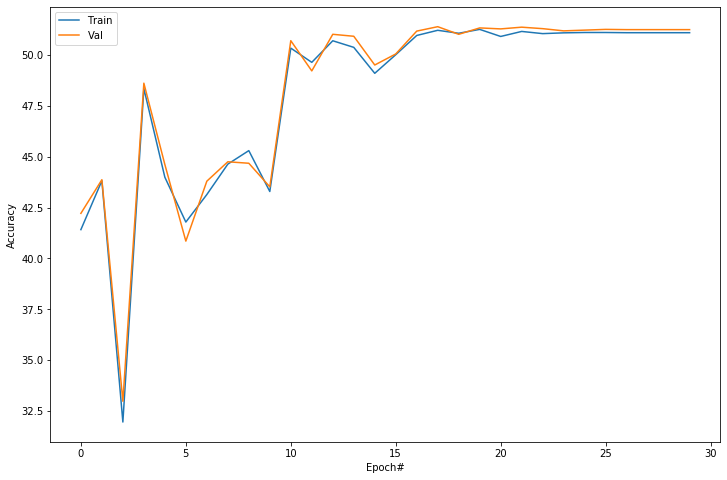

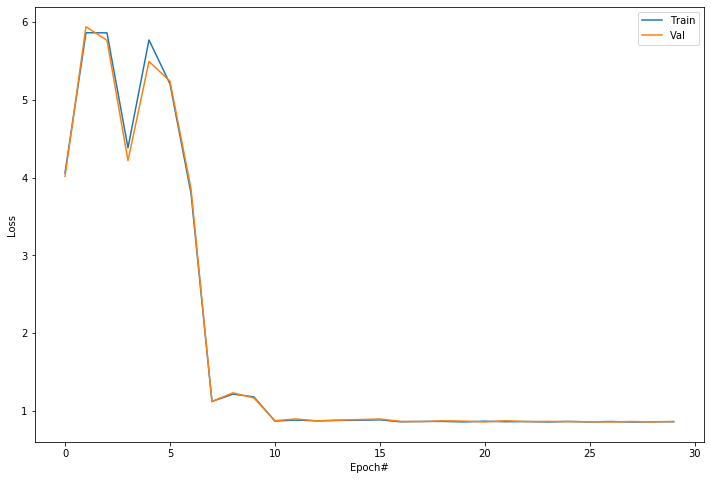

In [53]:
# Random initialization
run_model(model_state_dict=None, lr=0.01, num_epochs=30, model_suffix='random_init')

Epoch:1, Validation Accuracy:43.90, Training Acc: 44.14, Val Loss: 1.64919, Train Loss: 1.65379
Epoch:2, Validation Accuracy:40.54, Training Acc: 41.10, Val Loss: 1.54229, Train Loss: 1.53199
Epoch:3, Validation Accuracy:42.14, Training Acc: 42.35, Val Loss: 1.54389, Train Loss: 1.52171
Epoch     3: reducing learning rate of group 0 to 1.0000e-03.
Epoch:4, Validation Accuracy:43.21, Training Acc: 43.82, Val Loss: 1.79002, Train Loss: 1.74738
Epoch:5, Validation Accuracy:42.33, Training Acc: 43.34, Val Loss: 0.99819, Train Loss: 0.97498
Epoch:6, Validation Accuracy:45.59, Training Acc: 45.18, Val Loss: 0.97541, Train Loss: 0.97256
Epoch:7, Validation Accuracy:43.37, Training Acc: 43.21, Val Loss: 1.00820, Train Loss: 1.00165
Epoch:8, Validation Accuracy:46.12, Training Acc: 45.57, Val Loss: 0.99121, Train Loss: 0.99480
Epoch:9, Validation Accuracy:49.23, Training Acc: 49.02, Val Loss: 0.94551, Train Loss: 0.93937
Epoch:10, Validation Accuracy:38.64, Training Acc: 38.71, Val Loss: 1.0139

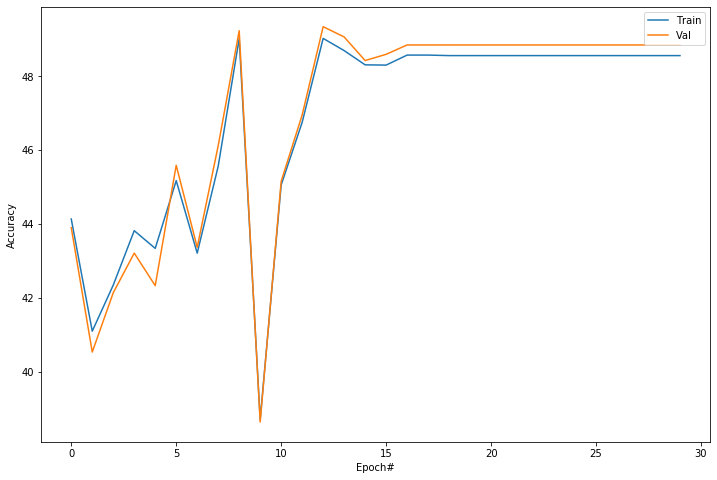

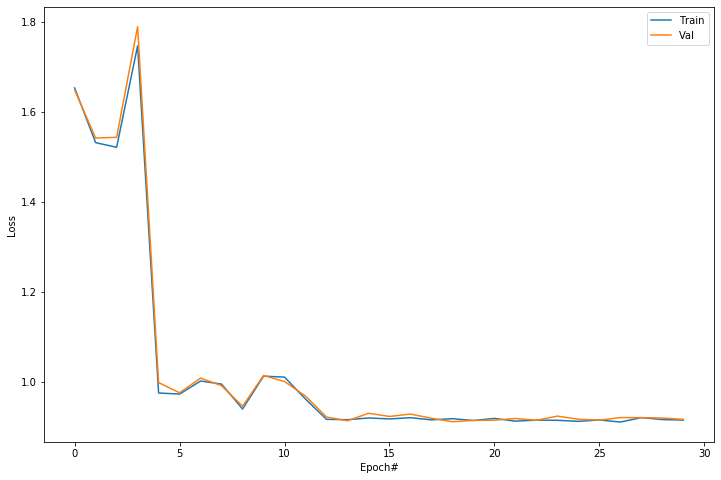

In [57]:
# Jigsaw initialization - 10/3
ref_msd = torch.load('/beegfs/sc6957/capstone/models/20191105/snet2_jigsaw_large_checkpoint_model_5.pth')['bestModelStateDict']

run_model(model_state_dict=ref_msd, lr=0.01, num_epochs=30, model_suffix='jigsaw_10_3_wfc_chkpnt_5')

Epoch:1, Validation Accuracy:40.49, Training Acc: 40.94, Val Loss: 1.40704, Train Loss: 1.41189
Epoch:2, Validation Accuracy:43.09, Training Acc: 42.66, Val Loss: 1.42461, Train Loss: 1.40962
Epoch:3, Validation Accuracy:39.24, Training Acc: 40.20, Val Loss: 1.77511, Train Loss: 1.71731
Epoch:4, Validation Accuracy:41.31, Training Acc: 41.19, Val Loss: 1.16043, Train Loss: 1.14331
Epoch     4: reducing learning rate of group 0 to 1.0000e-03.
Epoch:5, Validation Accuracy:33.57, Training Acc: 33.84, Val Loss: 1.38164, Train Loss: 1.39688
Epoch:6, Validation Accuracy:43.65, Training Acc: 43.54, Val Loss: 0.98921, Train Loss: 0.98036
Epoch:7, Validation Accuracy:48.59, Training Acc: 48.30, Val Loss: 0.95168, Train Loss: 0.94514
Epoch:8, Validation Accuracy:45.82, Training Acc: 45.26, Val Loss: 0.94415, Train Loss: 0.95624
Epoch:9, Validation Accuracy:45.28, Training Acc: 45.29, Val Loss: 0.99304, Train Loss: 0.97472
Epoch     9: reducing learning rate of group 0 to 1.0000e-04.
Epoch:10, Va

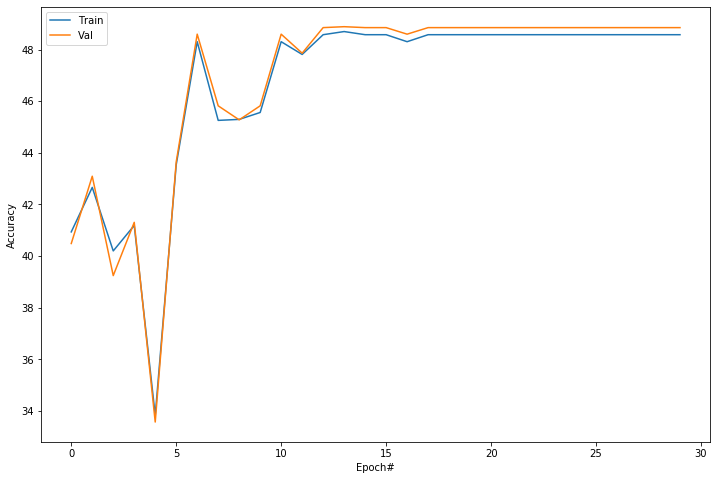

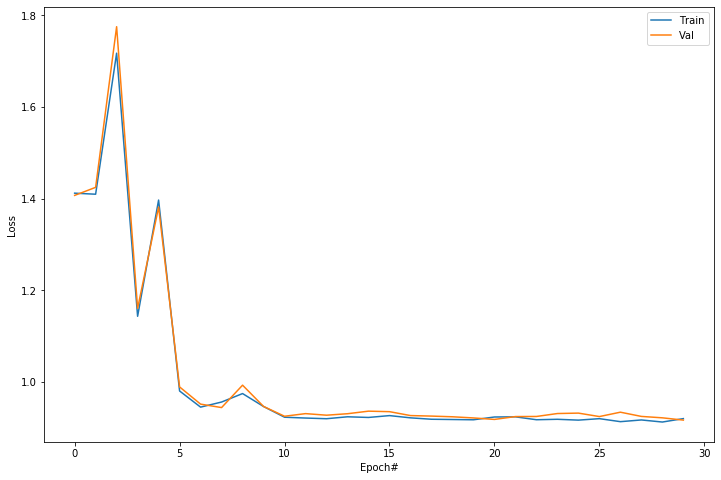

In [58]:
# Jigsaw initialization - 10/3
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191106/snet2_jigsaw_large_best_model.pth')['modelStateDict']

run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='jigsaw_10_3_wfc_best')

Epoch:1, Validation Accuracy:34.88, Training Acc: 35.03, Val Loss: 1.70538, Train Loss: 1.67405
Epoch:2, Validation Accuracy:41.89, Training Acc: 41.58, Val Loss: 1.40111, Train Loss: 1.38658
Epoch:3, Validation Accuracy:41.14, Training Acc: 40.73, Val Loss: 1.26763, Train Loss: 1.27080
Epoch:4, Validation Accuracy:42.85, Training Acc: 42.78, Val Loss: 1.28681, Train Loss: 1.26315
Epoch:5, Validation Accuracy:39.19, Training Acc: 38.83, Val Loss: 1.57345, Train Loss: 1.59087
Epoch:6, Validation Accuracy:44.59, Training Acc: 44.28, Val Loss: 1.30493, Train Loss: 1.30666
Epoch:7, Validation Accuracy:41.59, Training Acc: 41.34, Val Loss: 1.19198, Train Loss: 1.19545
Epoch:8, Validation Accuracy:38.73, Training Acc: 38.36, Val Loss: 1.46830, Train Loss: 1.45555
Epoch     8: reducing learning rate of group 0 to 1.0000e-03.
Epoch:9, Validation Accuracy:42.85, Training Acc: 42.61, Val Loss: 1.27393, Train Loss: 1.26335
Epoch:10, Validation Accuracy:47.76, Training Acc: 47.26, Val Loss: 0.9506

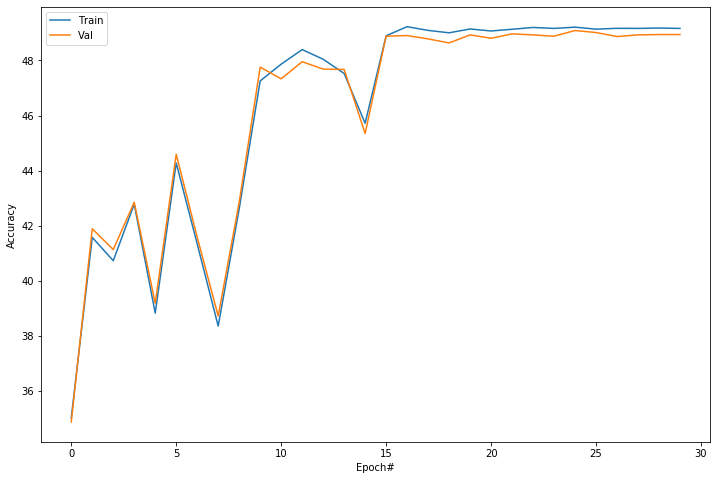

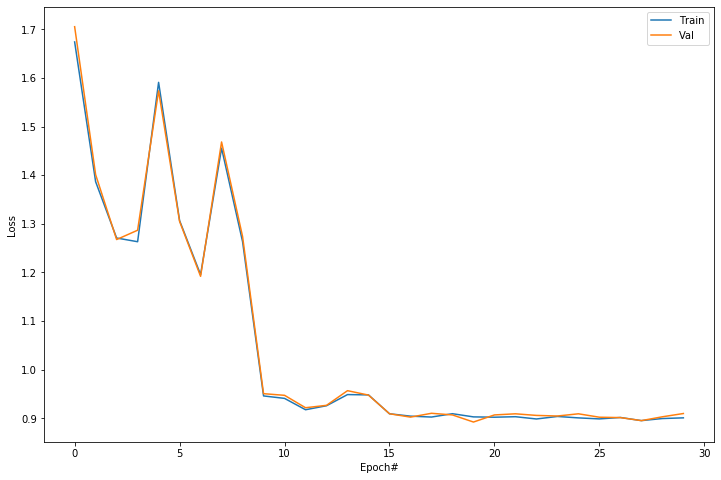

In [13]:
# TimeReversal initialization 
model_state_dict = torch.load('/beegfs/bva212/capstone/new_model/checkpoint_model.pth')['bestModelStateDict']
        
run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='time_reversal_chkpnt_15')

Epoch:1, Validation Accuracy:40.94, Training Acc: 40.55, Val Loss: 1.35276, Train Loss: 1.35066
Epoch:2, Validation Accuracy:42.20, Training Acc: 41.94, Val Loss: 1.31838, Train Loss: 1.36212
Epoch:3, Validation Accuracy:42.96, Training Acc: 42.80, Val Loss: 1.39984, Train Loss: 1.39039
Epoch:4, Validation Accuracy:42.24, Training Acc: 41.21, Val Loss: 1.17581, Train Loss: 1.18159
Epoch:5, Validation Accuracy:38.50, Training Acc: 38.59, Val Loss: 1.41338, Train Loss: 1.39981
Epoch     5: reducing learning rate of group 0 to 1.0000e-03.
Epoch:6, Validation Accuracy:40.80, Training Acc: 39.72, Val Loss: 1.25061, Train Loss: 1.25380
Epoch:7, Validation Accuracy:44.92, Training Acc: 45.42, Val Loss: 0.96885, Train Loss: 0.97465
Epoch:8, Validation Accuracy:48.43, Training Acc: 48.26, Val Loss: 0.92236, Train Loss: 0.92855
Epoch:9, Validation Accuracy:46.98, Training Acc: 46.54, Val Loss: 0.94105, Train Loss: 0.93303
Epoch:10, Validation Accuracy:47.78, Training Acc: 47.91, Val Loss: 0.9695

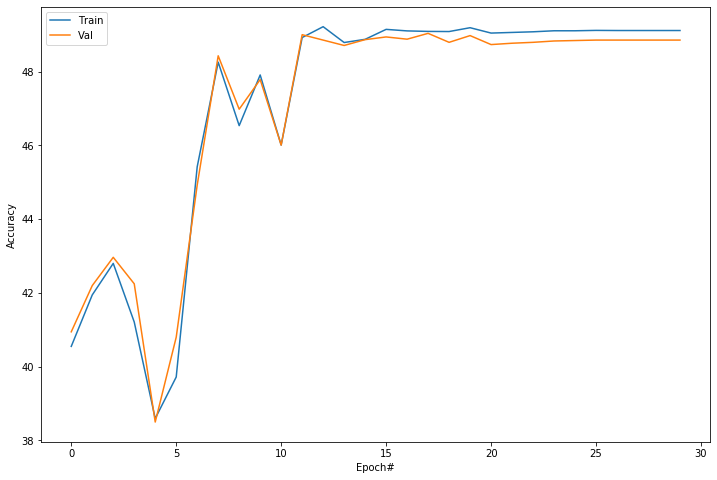

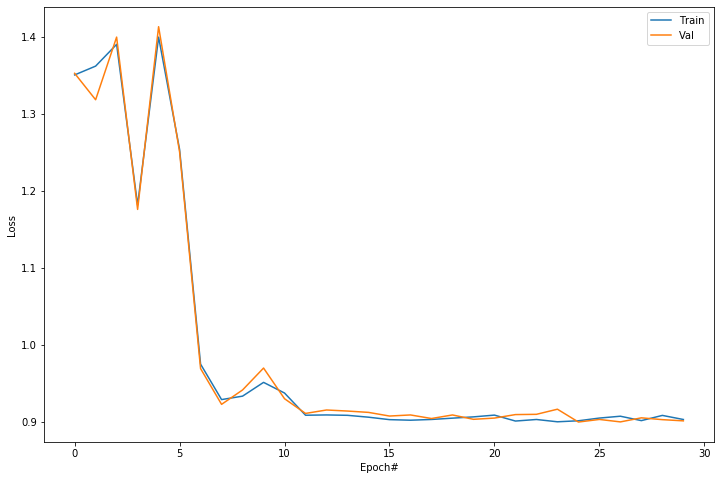

In [14]:
# TimeReversal initialization 
model_state_dict = torch.load('/beegfs/bva212/capstone/new_model/best_model.pth')['modelStateDict']
        
run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='time_reversal_best')

Epoch:1, Validation Accuracy:37.98, Training Acc: 37.41, Val Loss: 1.58137, Train Loss: 1.61294
Epoch:2, Validation Accuracy:40.14, Training Acc: 39.24, Val Loss: 1.65622, Train Loss: 1.65526
Epoch:3, Validation Accuracy:41.66, Training Acc: 42.47, Val Loss: 1.35144, Train Loss: 1.31632
Epoch:4, Validation Accuracy:40.46, Training Acc: 40.26, Val Loss: 1.88547, Train Loss: 1.92504
Epoch:7, Validation Accuracy:43.35, Training Acc: 43.26, Val Loss: 1.90721, Train Loss: 1.89184
Epoch:8, Validation Accuracy:37.55, Training Acc: 37.00, Val Loss: 1.46754, Train Loss: 1.46337
Epoch:9, Validation Accuracy:41.30, Training Acc: 41.36, Val Loss: 1.62643, Train Loss: 1.59741
Epoch     9: reducing learning rate of group 0 to 1.0000e-03.
Epoch:10, Validation Accuracy:39.09, Training Acc: 39.02, Val Loss: 1.48947, Train Loss: 1.46269
Epoch:11, Validation Accuracy:44.87, Training Acc: 45.26, Val Loss: 0.97525, Train Loss: 0.96319
Epoch:12, Validation Accuracy:39.87, Training Acc: 40.37, Val Loss: 0.99

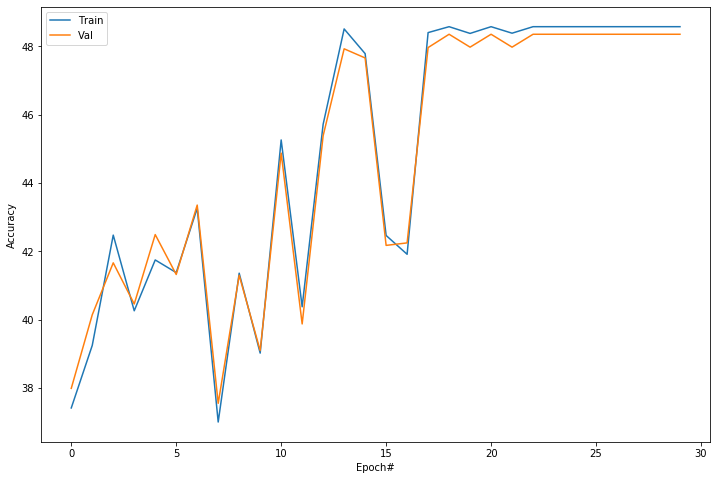

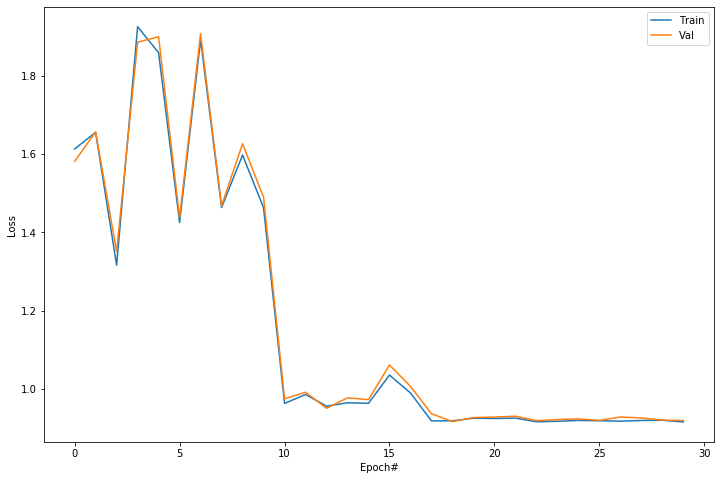

In [15]:
# Jigsaw initialization - 3/1 - w/fc
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191116/snet2_jigsaw_large_best_model.pth')['modelStateDict']

run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='jigsaw_3_1_wfc_best')

Epoch:1, Validation Accuracy:35.50, Training Acc: 35.68, Val Loss: 1.92858, Train Loss: 1.91335
Epoch:2, Validation Accuracy:38.74, Training Acc: 39.05, Val Loss: 1.54965, Train Loss: 1.53195
Epoch:3, Validation Accuracy:38.67, Training Acc: 38.58, Val Loss: 1.34661, Train Loss: 1.34186
Epoch:4, Validation Accuracy:42.03, Training Acc: 41.70, Val Loss: 1.55276, Train Loss: 1.53218
Epoch:5, Validation Accuracy:36.55, Training Acc: 36.34, Val Loss: 1.60372, Train Loss: 1.64066
Epoch:6, Validation Accuracy:39.75, Training Acc: 39.93, Val Loss: 1.60260, Train Loss: 1.58803
Epoch:7, Validation Accuracy:44.25, Training Acc: 44.70, Val Loss: 1.53051, Train Loss: 1.51780
Epoch:8, Validation Accuracy:41.87, Training Acc: 42.35, Val Loss: 1.67718, Train Loss: 1.63273
Epoch:9, Validation Accuracy:45.18, Training Acc: 44.54, Val Loss: 1.50275, Train Loss: 1.46676
Epoch:10, Validation Accuracy:44.30, Training Acc: 44.45, Val Loss: 1.58614, Train Loss: 1.56705
Epoch:11, Validation Accuracy:43.85, Tr

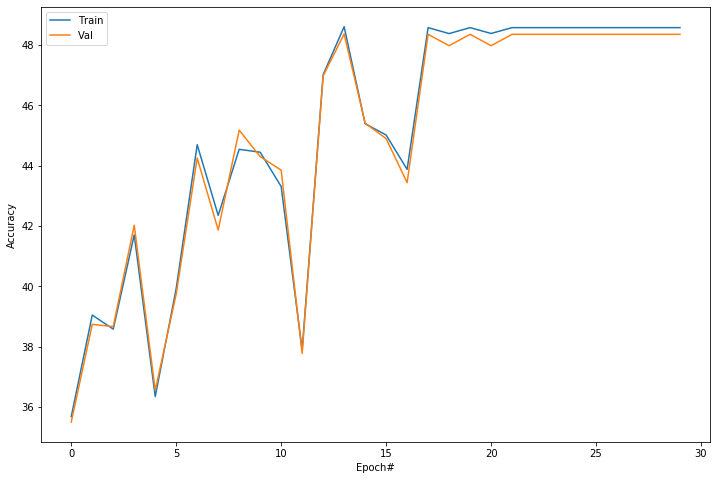

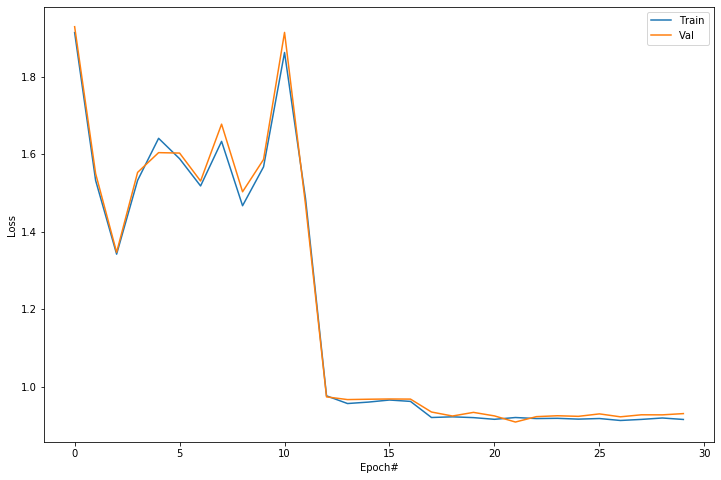

In [16]:
# Jigsaw initialization - 3/1
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191116/snet3_jigsaw_large_best_model.pth')['modelStateDict']

run_model(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='jigsaw_3_1_best')

In [20]:
model_file_path = './model/complete_dataset/downstream_frozen*'
results = {}
for model_file in glob(model_file_path):
    model_dict = torch.load(model_file)
    model_state_dict = model_dict['model_state_dict']
    model = AudioConvNet(fc=Identity())
    model.fc = SimpleMLP_Model()
    model.load_state_dict(model_state_dict)
    model.to(device)
    results_key = os.path.basename(model_file)[len('downstream_frozen_'):]
    results[results_key] = {}
    val_acc = np.array(model_dict['val_acc_list'])
    max_val_acc = max(val_acc)
    results[results_key]['val'] = (max_val_acc,  model_dict['val_loss_list'][np.where(val_acc == max_val_acc)[0][0]])
    results[results_key]['test'] = test_model(Test_loader, model)
 

key_order_map = {1: 'random_init', 2: 'jigsaw_10_3_wfc_chkpnt_5', 3: 'jigsaw_10_3_wfc_best', 4: 'jigsaw_3_1_wfc_best', 5: 'jigsaw_3_1_best', \
                             6: 'time_reversal_chkpnt_15', 7: 'time_reversal_best'}
model_test_results = OrderedDict((value, results[value]) for key, value in sorted(key_order_map.items()))
model_test_results

OrderedDict([('random_init',
              {'val': (51.381348775485584, 0.8640778256058693),
               'test': (68.62885857860732,
                0.8861826708316803,
                {'accordion': {'0.0': {'precision': 0.7835051546391752,
                   'recall': 1.0,
                   'f1-score': 0.8786127167630058,
                   'support': 152},
                  '1.0': {'precision': 0.0,
                   'recall': 0.0,
                   'f1-score': 0.0,
                   'support': 42},
                  'accuracy': 0.7835051546391752,
                  'macro avg': {'precision': 0.3917525773195876,
                   'recall': 0.5,
                   'f1-score': 0.4393063583815029,
                   'support': 194},
                  'weighted avg': {'precision': 0.6138803273461579,
                   'recall': 0.7835051546391752,
                   'f1-score': 0.6883975925153448,
                   'support': 194}},
                 'banjo': {'0.0': {'precision

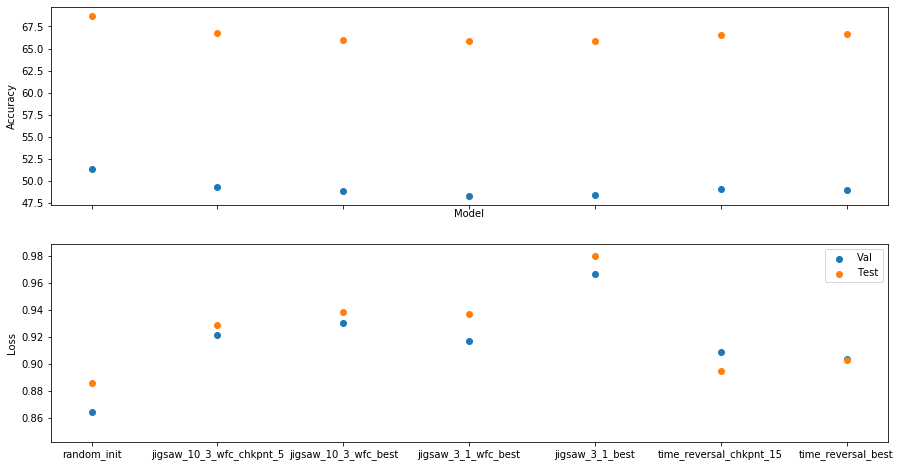

In [21]:
x = range(len(model_test_results))
key_list = list(model_test_results.keys())
values = np.array(list(model_test_results.values()))

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 8), sharex=True)

ax[0].scatter(x, [value['val'][0] for value in values], label='Val')
ax[0].scatter(x, [value['test'][0] for value in values], label='Test')
ax[0].set_ylabel('Accuracy')
ax[1].scatter(x, [value['val'][1] for value in values], label='Val')
ax[1].scatter(x, [value['test'][1] for value in values], label='Test')
ax[1].set_ylabel('Loss')

ax[0].set_xticks(x)    
ax[0].set_xticklabels(key_list, rotation=30)
ax[0].set_xlabel('Model')
# ax[0].legend(loc='best')
ax[1].legend(loc='best')

plt.show()

In [7]:
!sh call_analysis_code.sh

Submitted batch job 5827458
Submitted batch job 5827459
Submitted batch job 5827460
Submitted batch job 5827461
Submitted batch job 5827462
Submitted batch job 5827463
Submitted batch job 5827464


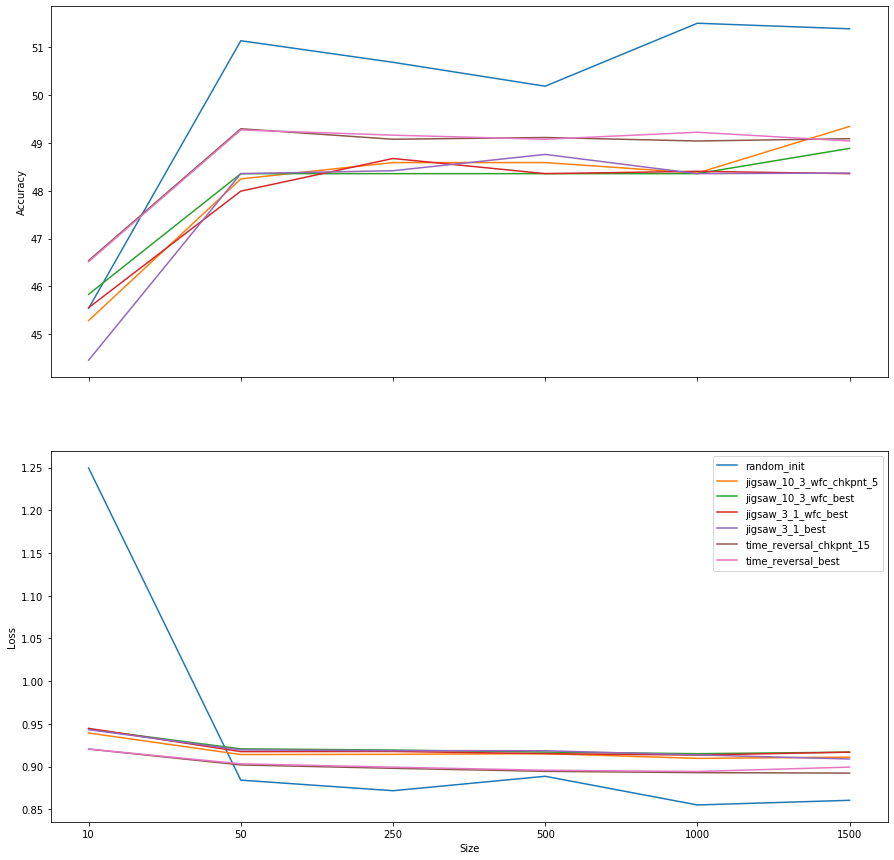

In [25]:
model_file_path = './model/limited_dataset/'
key_order_map = {1: 'random_init', 2: 'jigsaw_10_3_wfc_chkpnt_5', 3: 'jigsaw_10_3_wfc_best', 4: 'jigsaw_3_1_wfc_best', 5: 'jigsaw_3_1_best', \
                             6: 'time_reversal_chkpnt_15', 7: 'time_reversal_best'}
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 15), sharex=True)
for _, kvalue in sorted(key_order_map.items()):
    results = pickle.load(open(model_file_path+kvalue+'_trng_data_size_results.pkl', 'rb'))
    x = range(len(results))
    key_list = list(results.keys())
    values = np.array(list(results.values()))

    ax[0].plot([max(value['val_acc_list']) for value in values], label=kvalue)
    # ax[0].scatter(x, [value['test'][0] for value in values], label='Test')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot([min(value['val_loss_list']) for value in values], label=kvalue)
    # ax[1].scatter(x, [value['test'][1] for value in values], label='Test')
    ax[1].set_ylabel('Loss')

    ax[1].set_xticks(x)    
    ax[1].set_xticklabels(key_list)
    ax[1].set_xlabel('Size')
#     ax[0].legend(loc='best')
    ax[1].legend(loc='best')

plt.show()

In [64]:
r1 = re.compile('conv_layers')

def run_resnet(model_state_dict, lr, num_epochs, model_suffix):
    
    # Prepare/load model
    model = resnet18(num_class=2, fc=Identity())
    
    if model_state_dict is not None: 
        for key in list(model_state_dict.keys()):
            cs = r1.search(key)
            if cs is None:
                del model_state_dict[key]
#             elif cs.start() != 0:
#                 model_state_dict[key[cs.start():]] = model_state_dict[key]
#                 del model_state_dict[key]
#             print(model, model.state_dict().keys())
        model.load_state_dict(model_state_dict)
        
    for param in model.parameters():
            param.requires_grad = False
            
    model.fc = SimpleMLP_Model()
#     print(model, model.state_dict())
    model.to(device)

    # Train
    optimizer = torch.optim.Adam([param for param in model.parameters() if param.requires_grad == True], lr=0.01, weight_decay = 0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True, \
                                                           threshold=0.03, threshold_mode='abs', cooldown=0, min_lr=0, eps=1e-08)
    train_acc_list, train_loss_list, val_acc_list, val_loss_list, best_model_state_dict = train_model(Train_loader, Val_loader, \
                                                                                                      model, optimizer, scheduler, num_epochs)
    
    file_path = '/home/jk6373/self_supervised_machine_listening/code/downstream/model/complete_dataset/'
    file_name = 'downstream_frozen_' + model_suffix
    torch.save({
        'train_acc_list': train_acc_list,
        'train_loss_list': train_loss_list,
        'val_acc_list': val_acc_list,
        'val_loss_list': val_loss_list,
        'model_state_dict': best_model_state_dict
        }, file_path+file_name)

    #Plot
#     fig = plt.figure()
#     fig.set_size_inches(12,8)
#     plt.plot(train_acc_list, label='Train')
#     plt.plot(val_acc_list, label='Val')
#     plt.xlabel('Epoch#')
#     plt.ylabel('Accuracy')
#     plt.legend(loc='best')
#     plt.show()
    
#     fig = plt.figure()
#     fig.set_size_inches(12,8)
#     plt.plot(train_loss_list, label='Train')
#     plt.plot(val_loss_list, label='Val')
#     plt.xlabel('Epoch#')
#     plt.ylabel('Loss')
#     plt.legend(loc='best')
#     plt.show()
    
#     x = range(len(results))
#     key_list = list(results.keys())
#     values = np.array(list(results.values()))

    fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (15, 8), sharex=True)

    ax[0].plot(train_acc_list, label='Train')
    ax[0].plot(val_acc_list, label='Val')
    ax[0].set_ylabel('Accuracy')
    ax[1].plot(train_loss_list, label='Train')
    ax[1].plot(val_loss_list, label='Val')
    ax[1].set_ylabel('Loss')

#     ax[0].set_xticks(x)    
#     ax[0].set_xticklabels(key_list, rotation=30)
    ax[1].set_xlabel('Epoch#')
#     ax[0].legend(loc='best')
    ax[1].legend(loc='best')

    plt.show()

In [65]:
# Jigsaw initialization - ResNet - 10/3
model_state_dict = torch.load('/beegfs/sc6957/capstone/models/20191123/resnet_jigsaw_large_best_model.pth')['modelStateDict']

run_resnet(model_state_dict=model_state_dict, lr=0.01, num_epochs=30, model_suffix='jigsaw_3_1_best')

TypeError: forward() got an unexpected keyword argument 'num_classes'